In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#thread and progress bar
import concurrent.futures
from tqdm import tqdm

#preprocessing
import string
import re
string.punctuation
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

#plotting the data
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

#Model
from transformers import BertTokenizer, BertModel, TFBertModel, AdamW
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import gc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Understanding BERT

This is just to show and understand the inner working of BERT transformer but won't be used as model for our data

![BERT Schéma](https://drive.google.com/uc?export=view&id=1Iu_rP2pKieoOhe6xeKxVtlk0PCXGFXzN)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
class SimpleSelfAttention(torch.nn.Module):
    def __init__(self, embed_size):
        super(SimpleSelfAttention, self).__init__()
        self.embed_size = embed_size

        self.query_projection = nn.Linear(embed_size, embed_size)
        self.key_projection = nn.Linear(embed_size, embed_size)
        self.value_projection = nn.Linear(embed_size, embed_size)

        self.linear = nn.Linear(embed_size, embed_size)
        self.relu = nn.ReLU()

        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        # Project the input to obtain queries, keys, and values
        queries = self.query_projection(x)
        keys = self.key_projection(x)
        values = self.value_projection(x)

        # Compute scaled dot-product attention
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_scores = attention_scores / np.sqrt(self.embed_size)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply attention to values
        output = torch.matmul(attention_weights, values)

        # Add & Norm Layer
        output = self.layer_norm1(x + output)

        # Additional feedforward layer with ReLU activation
        output = self.linear(self.relu(self.linear(output)))

        # Add & Norm Layer
        output = self.layer_norm2(x + output)

        return output

class SimpleSelfAttentionClassifier(torch.nn.Module):
    def __init__(self, embed_size, num_classes):
        super(SimpleSelfAttentionClassifier, self).__init__()
        self.self_attention = SimpleSelfAttention(embed_size)
        self.classification = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        # Apply self-attention
        attention_output = self.self_attention(x)

        # Global average pooling to get a fixed-size representation
        pooled_output = attention_output.mean(dim=1)

        # Classification layer
        logits = self.classification(pooled_output)
        return logits

In [ ]:
embed_size = 64 #each token is a 64-d vector

# Create an instance of the model
attention_model = SimpleSelfAttention(embed_size)

# Example input
batch_size = 16 #during one iteration, 16 training examples simultaneously
sequence_length = 10
input_data = torch.randn(batch_size, sequence_length, embed_size)

# Forward pass through the attention model
output = attention_model(input_data)

print("Input shape:", input_data.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([16, 10, 64])
Output shape: torch.Size([16, 10, 64])


# Working with BERT



*   Dataset



In [ ]:
#snopes_df = pd.read_csv('drive/MyDrive/Colab Notebooks/TB/snopes_corpus_4.csv')
snopes_df = pd.read_csv('data/ukp_snopes_corpus/datasets_raw/snopes_corpus_4.csv')

In [ ]:
snopes_df.head()

,ID,Snopes URL,Claim,Truthfulness (Verdicts),Snippets (ETS),Source URL,Source,Documents (orginal documents),Match ETS and Documents
0,1,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> The Marines patrolling through the green f...,http://archive.boston.com/news/world/asia/arti...,Marines learn lessons from tragedy in Afghanis...,Marines learn lessons from tragedy in Afghanis...,match
1,2,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> An infantryman from Camp Pendleton's 3rd B...,,,,
2,3,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> We are asking everyone to say a prayer for...,,,,
3,4,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,<p> U.S. Marines who recently inherited this l...,,,,
4,5,http://www.snopes.com/inboxer/prayer/darkhorse...,Prayers are requested for the Darkhorse Marine...,OUTDATED,,https://web.archive.org/web/20081004102646/htt...,3rd Battalion 5th Marines History,"Starting in 1996, Alexa Internet has been dona...",


In [ ]:
snopes_df.columns

Index(['ID', 'Snopes URL', 'Claim', 'Truthfulness (Verdicts)',
       'Snippets (ETS)', 'Source URL', 'Source',
       'Documents (orginal documents)', 'Match ETS and Documents '],
      dtype='object')

In [ ]:
print(snopes_df['Truthfulness (Verdicts)'].value_counts().to_string())

FALSE                                                            11411
MIXTURE                                                           3556
TRUE                                                              2318
MOSTLY FALSE                                                      2132
UNPROVEN                                                          1845
 False                                                             995
 True                                                              640
MOSTLY TRUE                                                        540
LEGEND                                                             432
UNDETERMINED                                                       244
 Undetermined                                                      186
OUTDATED                                                           182
MIXTURE OF TRUE AND FALSE INFORMATION                              175
 Multiple                                                          164
MISCAP

In [ ]:
filtered_df = snopes_df[snopes_df['Truthfulness (Verdicts)'].isin(['FALSE', 'MIXTURE', 'TRUE', 'MOSTLY FALSE', 'MOSTLY TRUE', 'UNPROVEN'])]

filtered_df.head()

,ID,Snopes URL,Claim,Truthfulness (Verdicts),Snippets (ETS),Source URL,Source,Documents (orginal documents),Match ETS and Documents
11,12,http://www.snopes.com/rumors/perfume.asp,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",,,,
12,13,http://www.snopes.com/rumors/perfume.asp,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,,,,
13,14,http://www.snopes.com/rumors/perfume.asp,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,http://www.thestar.com.my/news/nation/2013/07/...,Gleneagles Hospital refutes hoax messages on p...,Gleneagles Hospital refutes hoax messages on p...,match
14,15,http://www.snopes.com/tornado-carries-mobile-h...,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",,,,
15,16,http://www.snopes.com/tornado-carries-mobile-h...,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,,,,


In [ ]:
print(filtered_df.columns)

Index(['ID', 'Snopes URL', 'Claim', 'Truthfulness (Verdicts)',
       'Snippets (ETS)', 'Source URL', 'Source',
       'Documents (orginal documents)', 'Match ETS and Documents '],
      dtype='object')


In [ ]:
filtered_df.rename(columns={
    'Truthfulness (Verdicts)': 'Verdict',
    'Snippets (ETS)': 'ETS',
    'Documents (orginal documents)': 'Document'
}, inplace=True)

columns_to_drop = ['ID', 'Snopes URL', 'Source URL', 'Match ETS and Documents ', 'Source', 'Document']
filtered_df.drop(columns_to_drop, axis=1, inplace=True)

<ipython-input-12-23b22b8626aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={
<ipython-input-12-23b22b8626aa>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns_to_drop, axis=1, inplace=True)


In [ ]:
print(filtered_df.columns)
print(filtered_df.isnull().any())
print(filtered_df.shape)

Index(['Claim', 'Verdict', 'ETS'], dtype='object')
Claim      False
Verdict    False
ETS        False
dtype: bool
(21802, 3)


In [ ]:
filtered_df.head()

,Claim,Verdict,ETS
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic..."
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th..."
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...


In [ ]:
print('5 random ETS where the verdict is TRUE:')
rEts = filtered_df.loc[filtered_df.Verdict == 'TRUE', ['ETS']].sample(5).values
for ets in rEts:
    print(ets[0])

5 random ETS where the verdict is TRUE:
 
 
<p>The spider that had the country talking after it caught and devoured a snake, found a new home on Friday.  </p> <p>Tania Robertson, a Bloemfontein secretary, was very relieved to get rid of her unwanted office mate.</p> <p>Leon Lotz of the department of arachnology at the National Museum in the city is now the proud owner of the poisonous button spider and what's left of the Aurora house snake.</p> <p>Robertson on Thursday appealed for someone to offer a new home to the spider that had been nesting in the air conditioning unit in her office.</p> <p>Lotz said the spider and snake would in future be used for educational purposes in the museum. The snake had been preserved in alcohol, while the spider was living in a covered jar on his desk.</p> <p>The spider and the remains of the snake will form part of an exhibition in the museum for years to come.</p> <p>He said these spiders lived about two years. When she dies, she would be added to oth

# Text preprocessing

In [ ]:
df = filtered_df.copy()
verdict_mapping = {
    'FALSE': 0,
    'MIXTURE': 1,
    'TRUE': 2,
    'MOSTLY FALSE': 3,
    'MOSTLY TRUE': 4,
    'UNPROVEN': 5
}

df['Numerical_Verdict'] = df['Verdict'].map(verdict_mapping)
df

,Claim,Verdict,ETS,Numerical_Verdict
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",0
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,0
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,0
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",0
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,0
...,...,...,...,...
25773,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>UNIFORMS FOR RETIRED PERSONNEL</p> <p>GENER...,0
25774,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>Now this is even low for the Clintons. Usin...,0
25775,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>4.1.2. A member of the Armed Forces on acti...,0
25776,Hillary Clinton paid an actor to dress up in N...,FALSE,,0


In [ ]:
print(df.shape)

(21802, 4)


In [ ]:
df =  df[df["ETS"].str.len() > 3] #Avoid keeping empty ETS
df

,Claim,Verdict,ETS,Numerical_Verdict
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",0
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,0
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,0
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",0
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,0
...,...,...,...,...
25771,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>Enlisted Surface Warfare Specialist Navy/Ma...,0
25772,Hillary Clinton paid an actor to dress up in N...,FALSE,"<p>“Oscar without the Navy, is like me without...",0
25773,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>UNIFORMS FOR RETIRED PERSONNEL</p> <p>GENER...,0
25774,Hillary Clinton paid an actor to dress up in N...,FALSE,<p>Now this is even low for the Clintons. Usin...,0


In [ ]:
print(df['Verdict'].value_counts())

FALSE           7187
MIXTURE         2367
TRUE            1636
MOSTLY FALSE    1348
UNPROVEN        1151
MOSTLY TRUE      315
Name: Verdict, dtype: int64


In [ ]:
def preprocess_text(text, remove_stopwords=True, remove_punctuation=True, remove_html=True):
    # Convert to lowercase
    text = text.lower()

    # Optionally remove HTML tags
    if remove_html:
        text = re.sub(r'<.*?>', '', text)

    # Optionally remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Optionally remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = word_tokenize(text)
        words = [word for word in words if word.lower() not in stop_words]
        text = ' '.join(words)

    return text

In [ ]:
# Function to apply preprocessing to a specific column with a progress bar
def apply_preprocessing_with_progress(df, column_name, stopwords=True, punctuation=True, html=True):
    tqdm.pandas(desc=f"Processing {column_name}", position=0, leave=False)
    # Apply preprocess_text function to all the data
    df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))

Preprocessing for the filtered_df so we can do EDA

In [ ]:
columns_to_process = ['ETS', 'Claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the tasks for each column
    futures = [executor.submit(apply_preprocessing_with_progress, filtered_df ,column_name) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

<ipython-input-21-f9f5a919d4c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))


In [ ]:
print('5 random ETS where the verdict is TRUE:')
rEts = filtered_df.loc[filtered_df.Verdict == 'TRUE', ['ETS']].sample(5).values
for ets in rEts:
    print(ets[0])

5 random ETS where the verdict is TRUE:
living room candidate presidential campaign commercials 19522012 online exhibition presenting 300 television commercials every election year since 1952 first campaign tv ads aired website updated 2012 election mitt romney barack obama site includes searchable database features commentary historical background election results navigation organized year type ad issue playlist feature allows visitors select annotate share groups ads view playlists guest contributors selected commercial accompanied list related ads transcript ad feature allows visitors search entire database title words transcripts
electoral college disaster democracy donald j trump realdonaldtrump november 7 2012

deer actually killed november 2 2008 privately owned ranch outside palestine texas piebald deer scored 138 58 gross total body weight 195 pounds husband getting deer full body mounted anyways wanted give information since lots emails going around saying deer harvested mich

# Exploratory data analysis

## Analysis of the "verdict" column

In [ ]:
print(filtered_df['Verdict'].value_counts())
print()
print('Normalized distribution : ')
print(filtered_df['Verdict'].value_counts(normalize=True))

FALSE           11411
MIXTURE          3556
TRUE             2318
MOSTLY FALSE     2132
UNPROVEN         1845
MOSTLY TRUE       540
Name: Verdict, dtype: int64

Normalized distribution : 
FALSE           0.523392
MIXTURE         0.163104
TRUE            0.106321
MOSTLY FALSE    0.097789
UNPROVEN        0.084625
MOSTLY TRUE     0.024768
Name: Verdict, dtype: float64


<Axes: title={'center': 'Normalized distribution of Verdict'}>

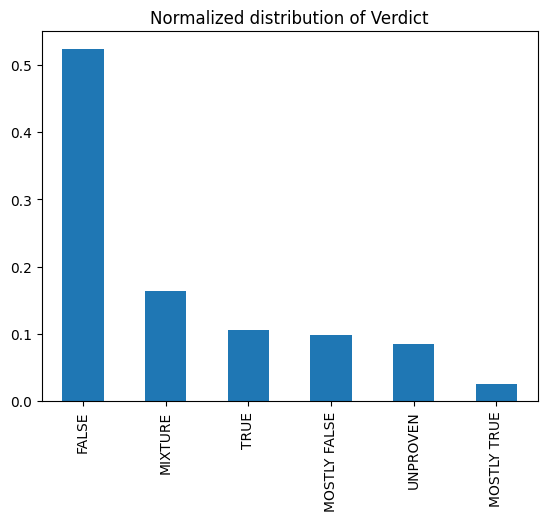

In [ ]:
filtered_df['Verdict'].value_counts(normalize=True).plot(kind='bar', title='Normalized distribution of Verdict')

The dataset is very unbalenced in favor of False verdict

In [ ]:
filtered_df.sample(5)

,Claim,Verdict,ETS
20550,photograph shows dog badly burned face,FALSE,people people isnt even dog found picture fasc...
8398,gang members targeting police cars civilian ve...,MIXTURE,addition threats police increased security pre...
231,inspirational internet postings recount high l...,MIXTURE,
249,father alexander fleming discoverer penicillin...,FALSE,british family journeyed scotland summer vacat...
5438,photograph shows cnn reporter anderson cooper ...,FALSE,bashing trump objectifying women anderson coop...


### Analysis of ETS column

In [ ]:
filtered_df['ets_length'] = filtered_df['ETS'].str.len()
average_text_length_by_verdict = filtered_df.groupby('Verdict')['ets_length'].mean()

<ipython-input-27-e1e9fb25038e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ets_length'] = filtered_df['ETS'].str.len()


<Axes: xlabel='Verdict'>

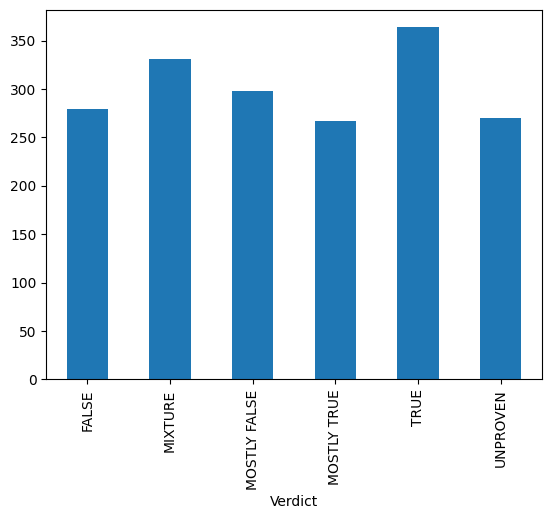

In [ ]:
average_text_length_by_verdict.plot(kind='bar')

Each verdict have a more or less close mean in terms of ETS lenght. This means that they each have the same amount of "proof"

In [ ]:
def gerenate_worldcloud_ets(verdict, remove_common_words=True):

  ets_string = ' '.join(filtered_df[filtered_df['Verdict']==verdict]['ETS'])

  if remove_common_words:
      common_words = ["said", "say", "one"]
      for word in common_words:
          ets_string = ets_string.replace(word, '')

  wordcloud = WordCloud()
  wordcloud.generate(ets_string)
  plt.imshow(wordcloud.to_image())
  plt.axis('off')
  plt.title('Worldcould for ETS with the verdict: ' + verdict)
  plt.show()

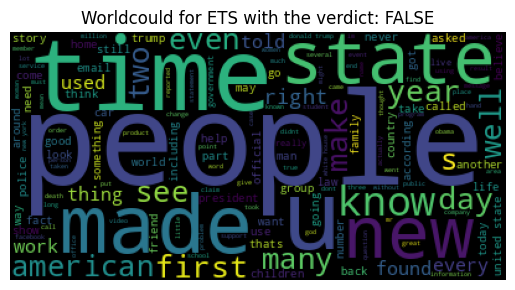

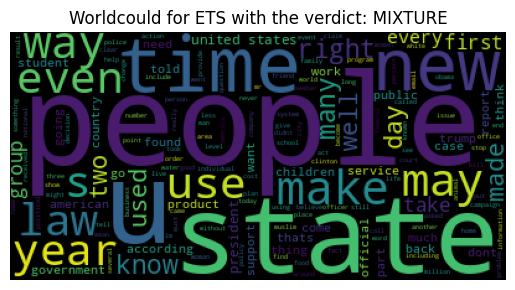

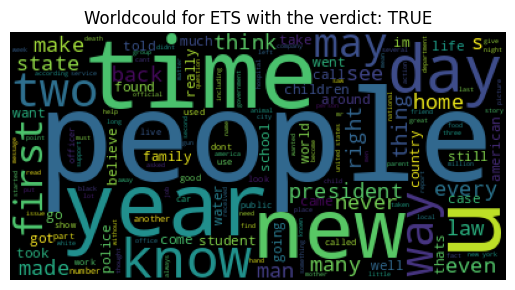

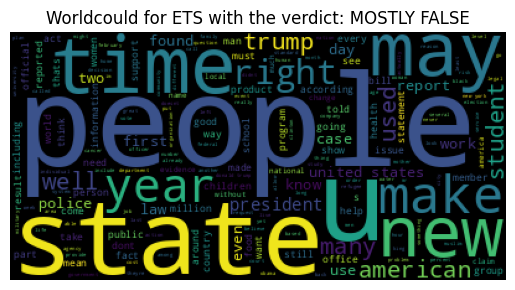

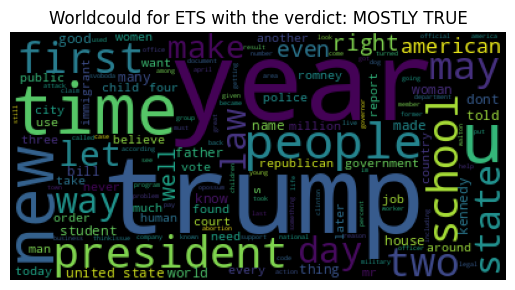

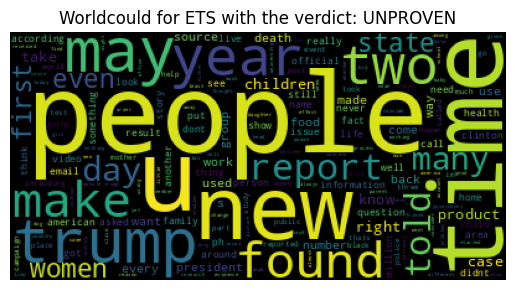

In [ ]:
verdicts = ['FALSE', 'MIXTURE', 'TRUE', 'MOSTLY FALSE', 'MOSTLY TRUE', 'UNPROVEN']

for v in verdicts:
  gerenate_worldcloud_ets(v)

In [ ]:
def get_top_bigram(verdict, remove_common_words=True, top_n=5):

  ets_string = ' '.join(filtered_df[filtered_df['Verdict']==verdict]['ETS'])

  if remove_common_words:
      common_words = ["said", "say", "one", '“', '”']
      for word in common_words:
          ets_string = ets_string.replace(word, '')

  # Tokenize the text into words
  words = word_tokenize(ets_string.lower())

  # Generate bigrams
  bigrams_list = list(bigrams(words))

  # Count the occurrences of each bigram
  bigram_counts = {}
  for bigram in bigrams_list:
      if bigram in bigram_counts:
          bigram_counts[bigram] += 1
      else:
          bigram_counts[bigram] = 1

  # Get the top N bigrams
  top_bigrams = sorted(bigram_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

  labels, counts = zip(*[(f"{bigram[0]} {bigram[1]}", count) for bigram, count in top_bigrams])

  # Plot the top bigrams
  plt.figure(figsize=(10, 6))
  plt.barh(labels, counts, color='skyblue')
  plt.xlabel('Frequency')
  plt.ylabel('Bigrams')
  plt.title('Top ' + str(top_n) + ' Bigrams for ETS with '+ verdict +' verdict')
  plt.show()

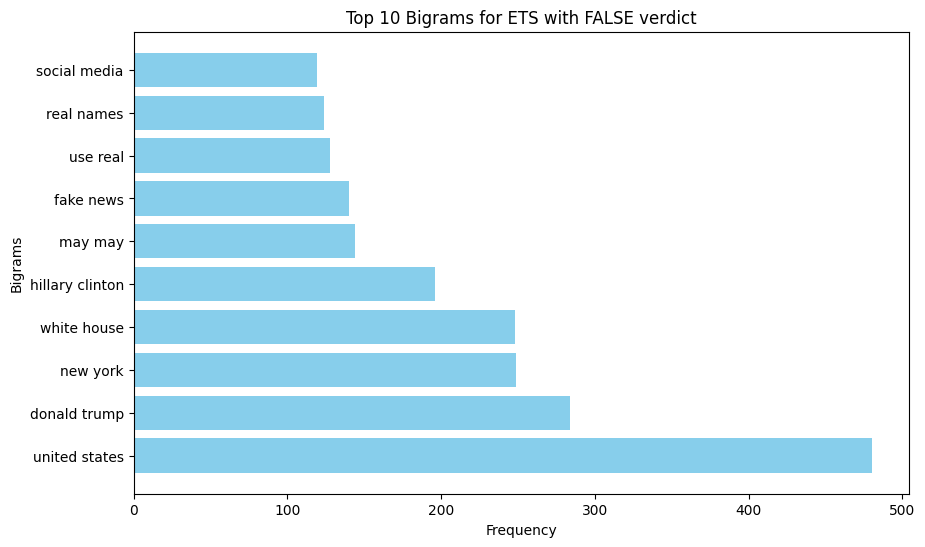

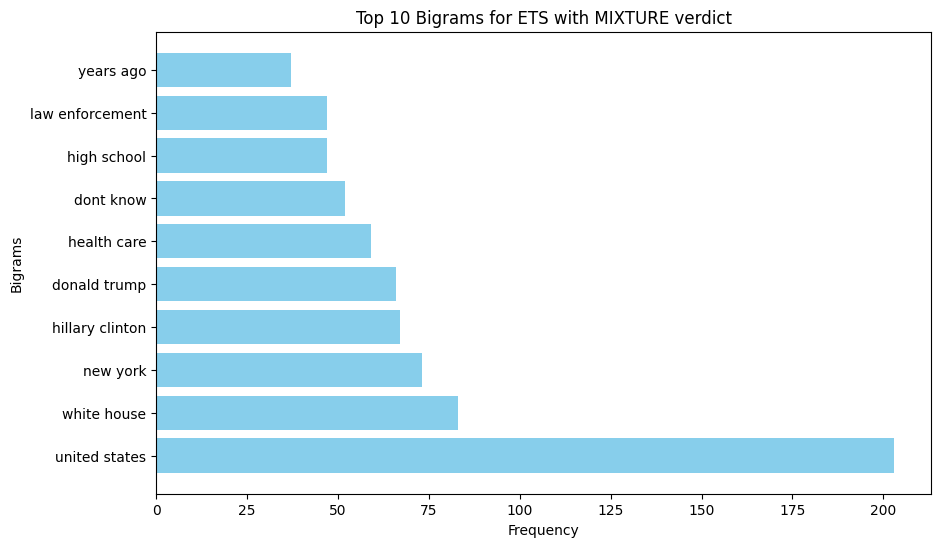

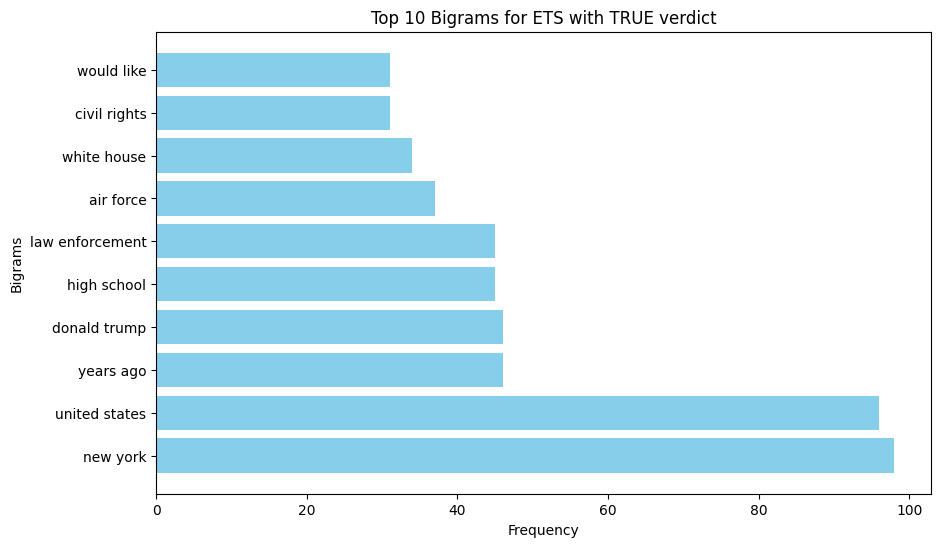

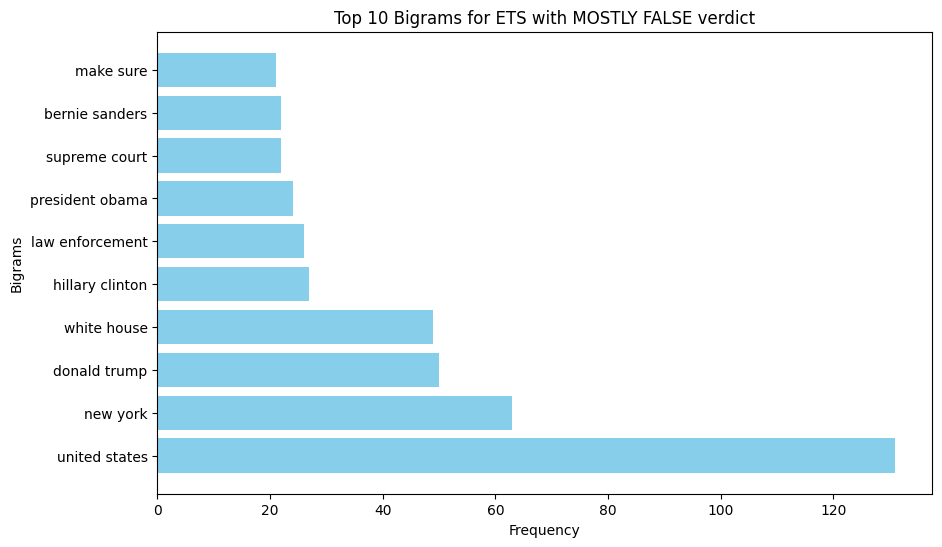

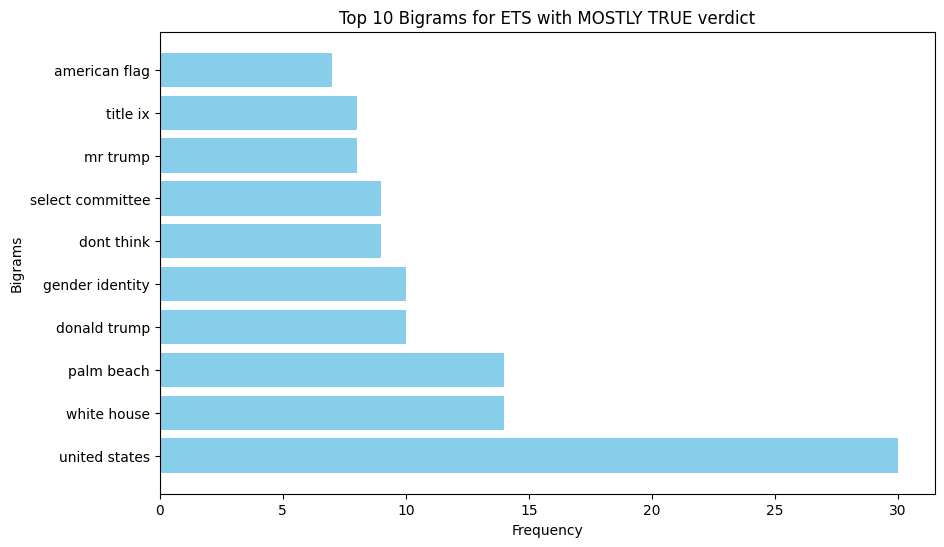

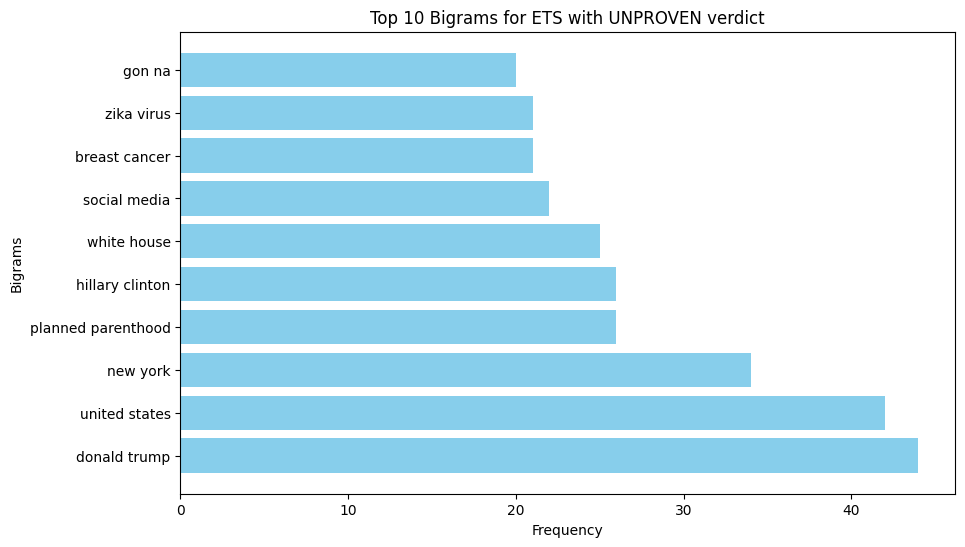

In [ ]:
for v in verdicts:
  get_top_bigram(v, top_n=10)

We can see that despite coming from the Snopes fact-checking web-site that treats all kind of facts. The UKP_Snopes dataset mainly consists of ETS related to the United States during the 2019 election compaign as there are no mention of President Biden in the top bigrams

# Bert Tokenizer

Preprocessing the data




In [ ]:
df.head()

,Claim,Verdict,ETS,Numerical_Verdict
11,Glen Eagles hospital issued an urgent warning ...,FALSE,"<p>Recently, an email and short message servic...",0
12,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>I can 100% confirm that the text message go...,0
13,Glen Eagles hospital issued an urgent warning ...,FALSE,<p>Gleneagles Hospital Kuala Lumpur has refute...,0
14,A tornado carried a mobile home for 130 miles ...,FALSE,"<p>A family from Tulsa, Oklahoma, underwent th...",0
15,A tornado carried a mobile home for 130 miles ...,FALSE,<p>WNDR assumes however all responsibility for...,0


In [ ]:
columns_to_process = ['ETS', 'Claim']

# Use concurrent.futures to run the process in parallel
with concurrent.futures.ThreadPoolExecutor() as executor2:
    # Submit the tasks for each column
    futures = [executor2.submit(apply_preprocessing_with_progress, df, column_name, punctuation=False, stopwords=False) for column_name in columns_to_process]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)

Processing ETS:  71%|███████▏  | 9986/14004 [00:00<00:00, 98714.86it/s]<ipython-input-21-f9f5a919d4c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].progress_apply(lambda x: preprocess_text(x, remove_stopwords=stopwords, remove_punctuation=punctuation, remove_html=html))


In [ ]:
df.head()

,Claim,Verdict,ETS,Numerical_Verdict
11,glen eagles hospital issued an urgent warning ...,FALSE,"recently, an email and short message service (...",0
12,glen eagles hospital issued an urgent warning ...,FALSE,i can 100% confirm that the text message going...,0
13,glen eagles hospital issued an urgent warning ...,FALSE,gleneagles hospital kuala lumpur has refuted a...,0
14,a tornado carried a mobile home for 130 miles ...,FALSE,"a family from tulsa, oklahoma, underwent the s...",0
15,a tornado carried a mobile home for 130 miles ...,FALSE,wndr assumes however all responsibility for th...,0


In [ ]:
rEts = df.loc[df.Verdict == 'TRUE', ['ETS']].sample(10).values
for ets in rEts:
    print(ets[0])

this antithesis is absurd because, on the one hand, there are so many scientific proofs in favor of evolution which appears to be a reality we can see and which enriches our knowledge of life and being as such. but on the other, the doctrine of evolution does not answer every query, especially the great philosophical question: where does everything come from? and how did everything start which ultimately led to man? i believe this is of the utmost importance.
i wasn't using any of them. they would have loved to have been involved with the campaign... look where the country is now on national policy. look where we are on defense... look at the mess we are in -whether it's the middle east or [anywhere] else and these were the people that have been there long time - washington establishment people.
deputy wood's shift had just concluded at about 1 a.m. on wednesday when he stopped by the 7-eleven off of shawnee drive and i-635 when three men entered the store. investigators say the men we

### Tokenizer

In [ ]:
def tokenize_column(df, column_name, tokenizer):
    # Convert the column to a list
    column_texts = df[column_name].tolist()

    # Tokenize each text
    tokenized_data = [tokenizer(text, truncation=True, padding='max_length', return_tensors = 'tf') for text in column_texts]

    # Add the tokenized data to the DataFrame
    df[column_name + '_tokenized'] = tokenized_data
    return df

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = tokenize_column(df, 'ETS', tokenizer)
df = tokenize_column(df, 'Claim', tokenizer)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-37-bdac8b32f1f0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '_tokenized'] = tokenized_data
<ipython-input-37-bdac8b32f1f0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name + '_tokenized'] = tokenized_data


In [ ]:
df

,Claim,Verdict,ETS,Numerical_Verdict,ETS_tokenized,Claim_tokenized
11,glen eagles hospital issued an urgent warning ...,FALSE,"recently, an email and short message service (...",0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
12,glen eagles hospital issued an urgent warning ...,FALSE,i can 100% confirm that the text message going...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
13,glen eagles hospital issued an urgent warning ...,FALSE,gleneagles hospital kuala lumpur has refuted a...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14,a tornado carried a mobile home for 130 miles ...,FALSE,"a family from tulsa, oklahoma, underwent the s...",0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
15,a tornado carried a mobile home for 130 miles ...,FALSE,wndr assumes however all responsibility for th...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
...,...,...,...,...,...,...
25771,hillary clinton paid an actor to dress up in n...,FALSE,enlisted surface warfare specialist navy/marin...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25772,hillary clinton paid an actor to dress up in n...,FALSE,"“oscar without the navy, is like me without a ...",0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25773,hillary clinton paid an actor to dress up in n...,FALSE,uniforms for retired personnel general. retire...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25774,hillary clinton paid an actor to dress up in n...,FALSE,now this is even low for the clintons. using a...,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


### Exploring the tokenized dataset

In [ ]:
columns_to_print = ['Claim', 'Claim_tokenized', 'ETS', 'ETS_tokenized']

for column in columns_to_print:
    # Get the data for the column
    data = df[column].iloc[0]

    if isinstance(data, str):
      print(f'Column: {column}')
      print(f'Untokenized text ({len(data)}): {data}')
    else:
      # Get the input_ids, token_type_ids, and attention_mask
      input_ids = data['input_ids'][0]
      token_type_ids = data['token_type_ids'][0]
      attention_mask = data['attention_mask'][0]

      # Print the input_ids, token_type_ids, and attention_mask
      print(f'Column: {column}')
      print(f'Input IDs ({len(input_ids)}): {input_ids}')
      print(f'Token Type IDs ({len(token_type_ids)}): {token_type_ids}') #in BERT, all tokens are treated as regular world so only we only have 0's
      print(f'Attention Mask ({len(attention_mask)}): {attention_mask}') # 1 if a regular word, 0 if it is padding
      print('================')


Column: Claim
Untokenized text (129): glen eagles hospital issued an urgent warning because seven women have died after sniffing perfume samples received in the mail. 
Column: Claim_tokenized
Input IDs (512): [  101  8904  8125  2902  3843  2019 13661  5432  2138  2698  2308  2031
  2351  2044 27646 17013  8168  2363  1999  1996  5653  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0 

In [ ]:
ex = df['Claim_tokenized'].iloc[0]['input_ids'][0]
print(f'Type of {ex} is ---> {type(ex)} ')

Type of [  101  8904  8125  2902  3843  2019 13661  5432  2138  2698  2308  2031
  2351  2044 27646 17013  8168  2363  1999  1996  5653  1012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0 

In [ ]:
df_tokenized = df.copy()

In [ ]:
df_tokenized.drop('Claim', axis=1, inplace=True)
df_tokenized.drop('Verdict', axis=1, inplace=True)
df_tokenized.drop('ETS', axis=1, inplace=True)

In [ ]:
df_tokenized

,Numerical_Verdict,ETS_tokenized,Claim_tokenized
11,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
12,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
13,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
14,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
15,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
...,...,...,...
25771,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25772,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25773,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"
25774,0,"[input_ids, token_type_ids, attention_mask]","[input_ids, token_type_ids, attention_mask]"


In [ ]:
print(df_tokenized['Numerical_Verdict'].value_counts(normalize=False))
print(df_tokenized['Numerical_Verdict'].value_counts(normalize=True))

0    7187
1    2367
2    1636
3    1348
5    1151
4     315
Name: Numerical_Verdict, dtype: int64
0    0.513211
1    0.169023
2    0.116824
3    0.096258
5    0.082191
4    0.022494
Name: Numerical_Verdict, dtype: float64


### Splitting the dataset (only with Claims and Verdict)

In [ ]:
X = df_tokenized["Claim_tokenized"]
y = df_tokenized["Numerical_Verdict"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(f'Shape of X:\n{X.shape}')
print(f'Shape of y:\n{y.shape}')
print()
print(f'Shape of X_train:\n{X_train.shape}')
print(f'Shape of y_train:\n{y_train.shape}')
print(f'Shape of X_test:\n{X_test.shape}')
print(f'Shape of y_test:\n{y_test.shape}')
print(f'Shape of X_val:\n{X_val.shape}')
print(f'Shape of y_test:\n{y_val.shape}')

Shape of X:
(14004,)
Shape of y:
(14004,)

Shape of X_train:
(8962,)
Shape of y_train:
(8962,)
Shape of X_test:
(2801,)
Shape of y_test:
(2801,)
Shape of X_val:
(2241,)
Shape of y_test:
(2241,)


Transform the tokenized data to the tensors (`tf.int32`) that BERT model requires

In [ ]:
def convert_to_tensor(df, token_type):
  converted_tensors = []
  for i in range(len(df)):
    data = df.iloc[i][token_type]
    converted_tensor = tf.convert_to_tensor(data, dtype=tf.int32)
    converted_tensors.append(converted_tensor)
  return tf.concat(converted_tensors, axis=0)

In [ ]:
train_input_ids = convert_to_tensor(X_train, token_type='input_ids')
train_attention_mask = convert_to_tensor(X_train, token_type='attention_mask')

In [ ]:
test_input_ids = convert_to_tensor(X_test, token_type='input_ids')
test_attention_mask = convert_to_tensor(X_test, token_type='attention_mask')

In [ ]:
val_input_ids = convert_to_tensor(X_val, token_type='input_ids')
val_attention_mask = convert_to_tensor(X_val, token_type='attention_mask')

# Building the BERT Model


![BERT Classifier](https://drive.google.com/uc?export=view&id=1Vs1h_SHk3P1gG6SP9Wsw2vHgmCTPZZ9-)

with only one Input (Claims or ETS)

In [ ]:
class BertClassifier(tf.keras.Model):
    def __init__(self, num_labels, max_length=128):
        super(BertClassifier, self).__init__()

        # BERT model layers
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')

        # Input layers
        self.input_ids = Input(shape=(max_length, ), dtype=tf.int32, name="input_ids")
        self.attention_mask = Input(shape=(max_length, ), dtype=tf.int32, name="attention_mask")

        # Dense layers for classification
        self.dense1 = Dense(128, activation='relu')
        self.output_layer = Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        # Extract inputs
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        # BERT forward pass
        print(f"Input IDs shape: {input_ids.shape}")
        print(f"Attention Mask shape: {attention_mask.shape}")

        bert_outputs = self.bert_model(input_ids, attention_mask=attention_mask)

        print(f"Bert Outputs keys: {bert_outputs.keys()}")
        pooled_output = bert_outputs.pooler_output

        # Dense layers for classification
        print(f"Pooled Output shape: {pooled_output.shape}")
        dense1_output = self.dense1(pooled_output)
        output = self.output_layer(dense1_output)

        print(f"Output shape: {output.shape}")
        return output

In [ ]:
model = BertClassifier(num_labels=6, max_length=512)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Dummy data for building the model
dummy_data = {
    'input_ids': tf.ones((1, 512), dtype=tf.int32),
    'attention_mask': tf.ones((1, 512), dtype=tf.int32)
}

# Call the model on the dummy data to build it
_ = model(dummy_data)

# Now we can print the model summary
model.summary()

Input IDs shape: (1, 512)
Attention Mask shape: (1, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (1, 768)
Output shape: (1, 6)
Model: "bert_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model (TFBertModel  multiple                  109482240 
 )                                                               
                                                                 
 dense (Dense)               multiple                  98432     
                                                                 
 dense_1 (Dense)             multiple                  774       
                                                                 
Total params: 109581446 (418.02 MB)
Trainable params: 109581446 (418.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Checking the shape of the inputs and targets before training the model

In [ ]:
train_input_ids

<tf.Tensor: shape=(11203, 512), dtype=int32, numpy=
array([[  101, 12495, 25832, ...,     0,     0,     0],
       [  101, 12583,  2024, ...,     0,     0,     0],
       [  101,  1037,  2817, ...,     0,     0,     0],
       ...,
       [  101,  9982, 11230, ...,     0,     0,     0],
       [  101, 17710,  9496, ...,     0,     0,     0],
       [  101,  3010,  7489, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
print(f'Shape and datatype of Input IDs:\n{train_input_ids.shape}\n{type(train_input_ids)}\n')
print(f'Shape and datatype of Attention Mask:\n{train_attention_mask.shape}\n{type(train_attention_mask)}\n')
print(f'Shape and datatype of y_train:\n{y_train.shape}\n{type(y_train)}')

Shape and datatype of Input IDs:
(11203, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of Attention Mask:
(11203, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of y_train:
(11203,)
<class 'pandas.core.series.Series'>


In [ ]:
print(f'Shape and datatype of Input IDs:\n{test_input_ids.shape}\n{type(test_input_ids)}\n')
print(f'Shape and datatype of Attention Mask:\n{test_attention_mask.shape}\n{type(test_attention_mask)}\n')
print(f'Shape and datatype of y_train:\n{y_test.shape}\n{type(y_test)}')

Shape and datatype of Input IDs:
(2801, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of Attention Mask:
(2801, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of y_train:
(2801,)
<class 'pandas.core.series.Series'>


In [ ]:
print(f'Shape and datatype of Input IDs:\n{val_input_ids.shape}\n{type(val_input_ids)}\n')
print(f'Shape and datatype of Attention Mask:\n{val_attention_mask.shape}\n{type(val_attention_mask)}\n')
print(f'Shape and datatype of y_val:\n{y_val.shape}\n{type(y_val)}')

Shape and datatype of Input IDs:
(2241, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of Attention Mask:
(2241, 512)
<class 'tensorflow.python.framework.ops.EagerTensor'>

Shape and datatype of y_train:
(2241,)
<class 'pandas.core.series.Series'>


## Training the model

Because of the RAM limit, the ammount of data and the number of parameters to train in a BERT model, the classifier model needs to be trained while iterating over subsets of the training data

In [ ]:
subset_size = 100
batch_size = 10
num_epochs = 3

In [ ]:
subset_input_ids = train_input_ids[:subset_size]
subset_attention_mask = train_attention_mask[:subset_size]
subset_labels = y_train[:subset_size]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    for i in range(subset_size // batch_size):
        start = i * batch_size
        end = (i + 1) * batch_size

        subset_batch_input_ids = subset_input_ids[start:end]
        subset_batch_attention_mask = subset_attention_mask[start:end]
        subset_batch_labels = subset_labels[start:end]

        # Train the model on the subset batch
        model.fit(
            {'input_ids': subset_batch_input_ids, 'attention_mask': subset_batch_attention_mask},
            subset_batch_labels,
            epochs=1,
            batch_size=batch_size
        )

        # Manually release memory and forces garbage collection
        del subset_batch_input_ids
        del subset_batch_attention_mask
        del subset_batch_labels
        gc.collect()

model.summary()

Subset Batch Input IDs Shape: (10, 512)
Subset Batch Attention Mask Shape: (10, 512)
Subset Batch Labels Shape: (10,)
1/1 [==============================] - 1s 1s/step - loss: 0.5822 - accuracy: 1.0000
Subset Batch Input IDs Shape: (10, 512)
Subset Batch Attention Mask Shape: (10, 512)
Subset Batch Labels Shape: (10,)
1/1 [==============================] - 1s 1s/step - loss: 0.3788 - accuracy: 1.0000
Subset Batch Input IDs Shape: (10, 512)
Subset Batch Attention Mask Shape: (10, 512)
Subset Batch Labels Shape: (10,)
1/1 [==============================] - 1s 1s/step - loss: 0.2717 - accuracy: 0.9000
Subset Batch Input IDs Shape: (10, 512)
Subset Batch Attention Mask Shape: (10, 512)
Subset Batch Labels Shape: (10,)
1/1 [==============================] - 1s 1s/step - loss: 0.6433 - accuracy: 0.7000
Subset Batch Input IDs Shape: (10, 512)
Subset Batch Attention Mask Shape: (10, 512)
Subset Batch Labels Shape: (10,)
1/1 [==============================] - 1s 1s/step - loss: 0.5783 - accurac

Almost each batch has a 100% accuracy, where the lowest is 70%. The loss is always before 0.5

## TO DO: Hyperparameter tuning

## TO REDO Evaluate the model

Was done before hyper parameter tuning -> DO AGAIN

In [ ]:
evaluation = model.evaluate({'input_ids': test_input_ids, 'attention_mask': test_attention_mask},
                            y_test,
                            batch_size=batch_size)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

Input IDs shape: (None, 512)
Attention Mask shape: (None, 512)
Bert Outputs keys: odict_keys(['last_hidden_state', 'pooler_output'])
Pooled Output shape: (None, 768)
Output shape: (None, 6)
281/281 [==============================] - 112s 389ms/step - loss: 1.4803 - accuracy: 0.5152
Test Loss: 1.480332612991333
Test Accuracy: 0.5151731371879578


The overall accuracy being 46.9% while the batch-level accuracy was between 70% and 100% might suggest overfitting during the training. This could be also because the batch size is too small the model might perform well on those specific samples but struggle to generalize when exposed to a larger and diverse set of examples during evaluation.

# Might use this later



one-hot encoder for targets

In [ ]:
# Assuming targets are one-hot encoded (using tf.keras.utils.to_categorical)
targets_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=6)
print(targets_one_hot)

Sliding window for documents

In [ ]:
# Creates overlapping windows of tokenized text for a given input text using a sliding window approach.
# This is done because a lot of the text data exeeds the maximum lenght accepted by the tokenizer
def sliding_window(text, tokenizer, window_size=512, stride=256):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')['input_ids']
    total_length = tokens.size(1)

     # If the text is shorter than window_size, create a window without padding
    if total_length <= window_size:
        # Adjust the window_size to the actual length of the text
        windows = [tokens[:, :total_length]]
    else:
        # Create windows with the specified stride
        windows = [tokens[:, i:i+window_size] for i in range(0, total_length, stride) if i+window_size <= total_length]

    return windows

In [ ]:
# Function to process sliding windows for a dataset
def process_windows(df, data_windows, tokenizer, stride=256, window_size=512):
    pbar = tqdm(total=len(df), desc=f"Processing {df.name}", position=0, leave=False)
    for i, text in enumerate(df):
        try:
            windows = sliding_window(text, tokenizer, window_size, stride)
            data_windows.extend(windows)
            pbar.update()
        except Exception as e:
            print(f"An error occurred: {e}")
    pbar.close()